# README

Do not run this file. This file just gives an overview of how data was posted to Hugging Face

# Do Preprocessing

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image

In [ ]:
from PIL import Image

def _make_square(im, min_size=300, fill_color=(38,153,57)):
    if im.mode != 'RGB':
        im = im.convert('RGB')
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [ ]:
!pip install datasets

  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset
#mediapipe dependencies
# import mediapipe as mp

#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

In [ ]:
# cleaned_ds
def _hf_rgb_image_transform(example):
    imgs = []
    for original_image in example['raw']:
        cleaned_image = rgb_image_transform(original_image)
        imgs.append(cleaned_image)
    example['image'] = imgs
    return example

In [ ]:
def add_col(ds, name):
    new_col = [None] * len(ds['train'])
    ds['train'] = ds['train'].add_column(name, new_col)
    new_col = [None] * len(ds['test'])
    ds['test'] = ds['test'].add_column(name, new_col)

In [ ]:
from datasets import ClassLabel
src_labels = ClassLabel(num_classes=3, names=['original', 'kaggle', 'blank'])
rps_labels = ClassLabel(num_classes=4, names=['paper', 'rock', 'scissors', 'none'])


## Original dataset

In [ ]:
hf = load_dataset("Javtor/rock-paper-scissors") # dataset images

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/372 [00:00<?, ? examples/s]

In [ ]:
hf = hf.rename_column('image', 'raw')
add_col(hf, 'image')

In [ ]:
hf = hf.map(_hf_rgb_image_transform, batched=True, batch_size=8, num_proc=4)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/2520 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/372 [00:00<?, ? examples/s]

In [ ]:
img_mode = hf['train'].features['raw']

In [ ]:
hf = hf.cast_column('image', img_mode)
hf = hf.cast_column('label', rps_labels)

Casting the dataset:   0%|          | 0/2520 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/372 [00:00<?, ? examples/s]

In [ ]:
hf['train'][0]['raw']

## Load kaggle

In [ ]:
!gdown --fuzzy 1ecEoW26HgbfdFY6PgYOGAQd6uQS_gu9-

Downloading...
From (original): https://drive.google.com/uc?id=1ecEoW26HgbfdFY6PgYOGAQd6uQS_gu9-
From (redirected): https://drive.google.com/uc?id=1ecEoW26HgbfdFY6PgYOGAQd6uQS_gu9-&confirm=t&uuid=fe892b2f-75fa-4752-a3fc-9251add7e0ee
To: /content/archive (4).zip
100% 321M/321M [00:02<00:00, 150MB/s]


In [ ]:
# add in Rock-Paper-Scissors Images, obtained from https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?resource=download
%%capture
!unzip "archive (4).zip"
!rm -r ./scissors
!rm -r ./rock
!rm -r ./paper

In [ ]:
# load from image folder
kaggle_ds = load_dataset("rps-cv-images", data_dir="")

Resolving data files:   0%|          | 0/2189 [00:00<?, ?it/s]

In [ ]:
kaggle_ds = kaggle_ds['train'].train_test_split(test_size=0.2, seed=42)
# nice, the labels are already good, no need to adjust

In [ ]:
kaggle_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 438
    })
})

In [ ]:
kaggle_ds = kaggle_ds.rename_column('image', 'raw')
add_col(kaggle_ds, 'image')

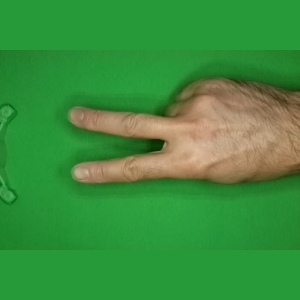

In [ ]:
_make_square(kaggle_ds['train'][1500]['raw'])

In [ ]:
def _hf_make_square(batch):
    batch['image'] = [_make_square(x) for x in batch['raw']]
    return batch

In [ ]:
kaggle_ds = kaggle_ds.map(_hf_make_square, batched=True, batch_size=32, num_proc=4)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1750 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/438 [00:00<?, ? examples/s]

In [ ]:
kaggle_ds = kaggle_ds.cast_column("image", img_mode)
kaggle_ds = kaggle_ds.cast_column('label', rps_labels)

In [ ]:
kaggle_ds['train'][500]['raw'].size

(300, 200)

## Download backgrounds

In [ ]:
%%capture
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets list

In [ ]:
# https://paperswithcode.com/dataset/bg-20k provides backgrounds, possibly for blank datasets
!kaggle datasets download -d nguyenquocdungk16hl/bg-20o

100% 13.1G/13.1G [03:03<00:00, 117MB/s]
100% 13.1G/13.1G [03:03<00:00, 76.9MB/s]


In [ ]:
!unzip "bg-20o.zip" "1/*"
!unzip "bg-20o.zip" "2/*"

In [ ]:
!ls ./1/BG-20k/train | wc -l

1682


In [ ]:
!mkdir BG20k
!mkdir BG20k/train
!mkdir BG20k/test
!mv ./1/BG-20k/train/* ./BG20k/train
!mv ./2/BG-20k/train/* ./BG20k/train
# it's about a 50-50 split
!mv ./1/BG-20k/testval/* ./BG20k/test
!mv ./2/BG-20k/testval/* ./BG20k/test

mkdir: cannot create directory ‘BG20k’: File exists


In [ ]:
# it's about 50-50. we'll need to resplit
!mv ./BG20k/test/* ./BG20k/train
!rm  -r ./BG20k/test
!mv ./BG20k/train/* ./BG20k

mv: cannot stat './BG20k/test/*': No such file or directory
rm: cannot remove './BG20k/test': No such file or directory


In [ ]:
!ls ./BG20k/train | wc -l

6125


In [ ]:
blank_ds = load_dataset("BG20k", data_dir="")
# blank_ds['train'].train_test_split(test_size=0.2, seed=42)

Resolving data files:   0%|          | 0/6125 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['image'],
        num_rows: 1225
    })
})

In [ ]:
blank_ds = blank_ds.map(_hf_rgb_image_transform, batched=True, batch_size=8, num_proc=4)

In [ ]:
blank_ds

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 6125
    })
})

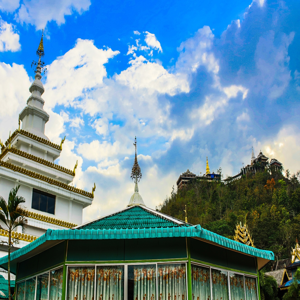

In [ ]:
blank_ds['train'][70]['image']

In [ ]:
blank_ds = blank_ds['train'].train_test_split(test_size=0.2, seed=42)

In [ ]:
for i in range(len(blank_ds['train'])):
    blank_ds['train'][i]['label'] = 4
for i in range(len(blank_ds['test'])):
    blank_ds['test'][i]['label'] = 4

In [ ]:
blank_labels = [4] * len(blank_ds['train'])
blank_ds['train'] = blank_ds['train'].add_column('label', blank_labels)
blank_labels = [4] * len(blank_ds['test'])
blank_ds['test'] = blank_ds['test'].add_column('label', blank_labels)

In [ ]:
blank_ds['train'][0]['label']

4

In [ ]:
def permute_image(example):
    original_image = example['image']  # Assuming 'image' is the key for the image tensor
    permuted_image = original_image.permute(0, 3, 1, 2)  # Permute dimensions for batch size of 8
    example['image'] = permuted_image  # Update the example with the permuted image
    return example

# Apply the function to the entire dataset
permuted_dataset = ds_shuffled.map(permute_image, batched=True, batch_size=8)
permuted_dataset.set_format('torch', dtype=torch.uint8) # of course huggingface converts it to int64

## Download Backgrounds (already processed skip)

In [ ]:
prev_ds = load_dataset("conjunct/rps_dataset")

In [ ]:
blank_ds = prev_ds.filter(lambda x: x['src'] == 2)

In [ ]:
blank_ds = blank_ds.remove_columns(['src', 'annotated', 'landmarks_old', 'pca', 'landmarks'])

In [ ]:
blank_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1225
    })
})

In [ ]:
blank_ds = blank_ds.rename_column('image', 'raw')
add_col(blank_ds, 'image')
# blank_ds = blank_ds.map(_hf_rgb_image_transform, batched=True, batch_size=8, num_proc=4)


In [ ]:
def _ident(x):
    x['image'] = x['raw']
    return x
blank_ds = blank_ds.map(_hf_rgb_image_transform, batched=True, batch_size=32, num_proc=4)

In [ ]:
blank_ds = blank_ds.cast_column("image", img_mode)

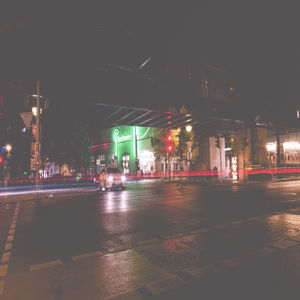

In [ ]:
blank_ds['train'][0]['image']

In [ ]:
def adjust_labels_blank(batch):
    batch["label"] = [3 for _ in batch['label']]
    return batch
blank_ds = blank_ds.map(adjust_labels_blank, batched=True)
blank_ds = kaggle_ds.cast_column('label', rps_labels)

## Merge datasets

In [ ]:
hf['train'].features

{'raw': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['paper', 'rock', 'scissors', 'none'], id=None),
 'image': Image(mode=None, decode=True, id=None)}

In [ ]:
from datasets import ClassLabel
src_labels = ClassLabel(num_classes=3, names=['original', 'kaggle', 'blank'])
rps_labels = ClassLabel(num_classes=4, names=['paper', 'rock', 'scissors', 'none'])

In [ ]:
src_labels = ClassLabel(num_classes=3, names=['original', 'kaggle', 'blank'])
features = hf['train'].features.copy()
features['label'] = rps_labels
features['src'] = src_labels
features

{'raw': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['paper', 'rock', 'scissors', 'none'], id=None),
 'image': Image(mode=None, decode=True, id=None),
 'src': ClassLabel(names=['original', 'kaggle', 'blank'], id=None)}

In [ ]:
hf, kaggle_ds, blank_ds

(DatasetDict({
     train: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 2520
     })
     test: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 372
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 1750
     })
     test: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 438
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 4900
     })
     test: Dataset({
         features: ['raw', 'label', 'image'],
         num_rows: 1225
     })
 }))

In [ ]:
def add_src(ds, src):
    srcs = [src] * len(ds['train'])
    ds['train'] = ds['train'].add_column('src', srcs)

    srcs = [src] * len(ds['test'])
    ds['test'] = ds['test'].add_column('src', srcs)
    return ds

hf = add_src(hf, 0)
kaggle_ds = add_src(kaggle_ds, 1)
blank_ds = add_src(blank_ds, 2)

In [ ]:
blank_ds

In [ ]:
hf = hf.cast_column('src', src_labels)
kaggle_ds = kaggle_ds.cast_column('src', src_labels)
blank_ds = blank_ds.cast_column('src', src_labels)

In [ ]:
from datasets import concatenate_datasets
merged_ds_train = concatenate_datasets([hf['train'], kaggle_ds['train'], blank_ds['train']])
merged_ds_test = concatenate_datasets([hf['test'], kaggle_ds['test'], blank_ds['test']])
from datasets import DatasetDict
merged_ds = DatasetDict({
    'train': merged_ds_train,
    'test': merged_ds_test
})

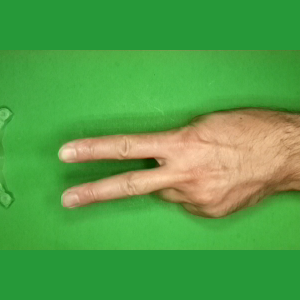

In [ ]:
merged_ds['train'][3900]['image']

# Save changes

In [ ]:
!huggingface-cli login
merged_ds.push_to_hub("conjunct/rps_raw")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/2293 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Map:   0%|          | 0/2293 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Map:   0%|          | 0/2292 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Map:   0%|          | 0/2292 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1018 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Map:   0%|          | 0/1017 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/conjunct/rps_raw/commit/1d69c153c1e11681e46785f68157b072599def26', commit_message='Upload dataset', commit_description='', oid='1d69c153c1e11681e46785f68157b072599def26', pr_url=None, pr_revision=None, pr_num=None)

# Add joints

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils  # used to draw landmarks
mp_hands = mp.solutions.hands  # used to get landmarks from a photo

In [ ]:
# merged_ds = load_dataset("conjunct/rps_raw") # checkpoint

# Save changes

In [ ]:
merged_ds.push_to_hub("conjunct/rps_dataset")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/3057 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Map:   0%|          | 0/3057 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Map:   0%|          | 0/3056 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/31 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/544 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/conjunct/rps_dataset/commit/fd0d81ddcf8003d0872dd25f7890bc1e5669b764', commit_message='Upload dataset', commit_description='', oid='fd0d81ddcf8003d0872dd25f7890bc1e5669b764', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# !pip install huggingface_hub
# !huggingface-cli login
torch_compat_ds.push_to_hub("conjunct/rps_dataset")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.c

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/conjunct/rps_dataset/commit/bbb65ffdd139e76469d3fbdc04e97ad61031d8c6', commit_message='Upload dataset', commit_description='', oid='bbb65ffdd139e76469d3fbdc04e97ad61031d8c6', pr_url=None, pr_revision=None, pr_num=None)

# Show exa

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

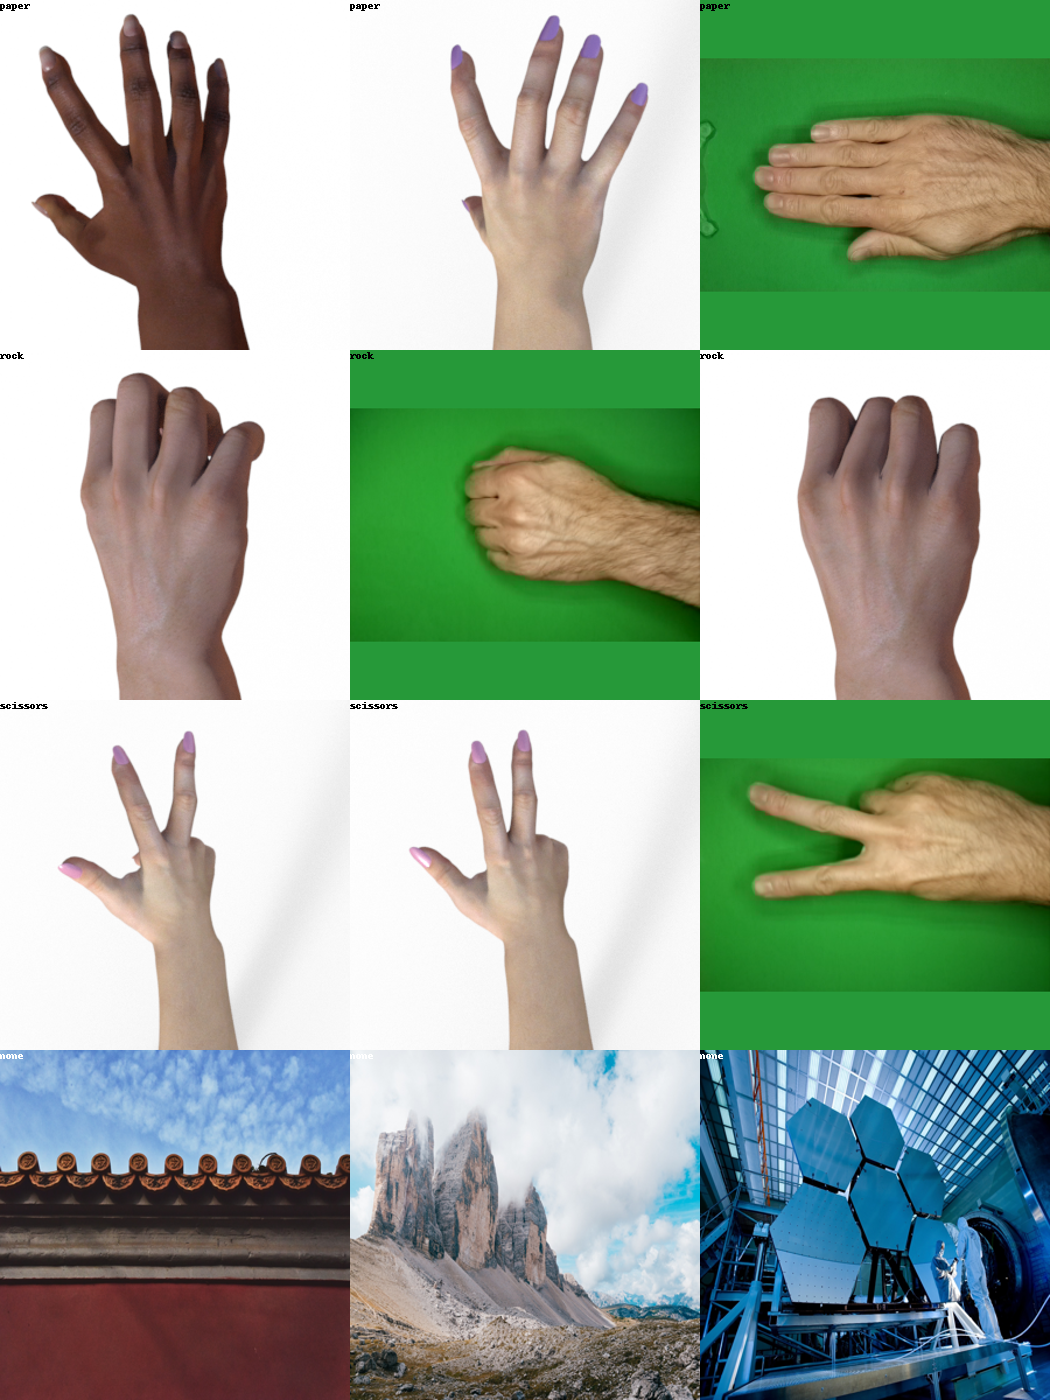

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].shuffle(seed).select(range(100)).filter(lambda ex: ex['label'] == label_id).select(range(examples_per_class))
        # ds_slice = ds.shuffle(seed).select(range(examples_per_class))
        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)

            hue = (0, 0, 0) if label_id < 3 else (255, 255, 255)
            draw.text(box, label, hue) # , font=font)

    return grid

show_examples(merged_ds, seed=random.randint(0, 1337), examples_per_class=3)